In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [2]:
!pip install ucimlrepo


from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split
import sys
import os
import pandas as pd



Defaulting to user installation because normal site-packages is not writeable


In [3]:
# Caminho absoluto para a pasta src
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
src_path_2 = os.path.abspath(os.path.join(os.getcwd(), '..', 'src/modelos'))
sys.path.append(src_path)
sys.path.append(src_path_2)

from model_wizard import buscar_melhor_wisard
from model_mlp import busca_melhores_mlp
from tratamento_dados import preprocess_data,preprocess_data_standart_scale
from metricas import plot_confusion_matrix, classification_metrics

## Quarto Dataset

In [4]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
letter_recognition = fetch_ucirepo(id=59) 
  
# data (as pandas dataframes) 
X = letter_recognition.data.features 
y = letter_recognition.data.targets 
  
# metadata 
print(letter_recognition.metadata) 
  
# variable information 
print(letter_recognition.variables) 


{'uci_id': 59, 'name': 'Letter Recognition', 'repository_url': 'https://archive.ics.uci.edu/dataset/59/letter+recognition', 'data_url': 'https://archive.ics.uci.edu/static/public/59/data.csv', 'abstract': 'Database of character image features; try to identify the letter', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 20000, 'num_features': 16, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['lettr'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1991, 'last_updated': 'Thu Sep 28 2023', 'dataset_doi': '10.24432/C5ZP40', 'creators': ['David Slate'], 'intro_paper': None, 'additional_info': {'summary': 'The objective is to identify each of a large number of black-and-white rectangular pixel displays as one of the 26 capital letters in the English alphabet.  The character images were based on 20 different fonts and each letter within these 20 fonts wa

### Visualização de datasets

In [5]:
import numpy as np
print("Features:")
print(X.head())
print("\nTargets únicos:")
print(np.unique(y))

# Identificar colunas categóricas e numéricas
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()

print("\nColunas categóricas:", categorical_cols)
print("Colunas numéricas:", numeric_cols)

Features:
   x-box  y-box  width  high  onpix  x-bar  y-bar  x2bar  y2bar  xybar  x2ybr  \
0      2      8      3     5      1      8     13      0      6      6     10   
1      5     12      3     7      2     10      5      5      4     13      3   
2      4     11      6     8      6     10      6      2      6     10      3   
3      7     11      6     6      3      5      9      4      6      4      4   
4      2      1      3     1      1      8      6      6      6      6      5   

   xy2br  x-ege  xegvy  y-ege  yegvx  
0      8      0      8      0      8  
1      9      2      8      4     10  
2      7      3      7      3      9  
3     10      6     10      2      8  
4      9      1      7      5     10  

Targets únicos:
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']

Colunas categóricas: []
Colunas numéricas: ['x-box', 'y-box', 'width', 'high', 'onpix', 'x-bar', 'y-bar', 'x2bar', 'y2bar', 'xybar', 'x2ybr', 'x

### Tratamento de Dados

In [6]:
X_processed, y_encoded, le = preprocess_data(X, y, categorical_cols, numeric_cols)
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)
# Exibe as dimensões dos conjuntos de treino e teste
print("Tamanho do conjunto de treino:", X_train.shape)
print("Tamanho do conjunto de teste:", X_test.shape)
print("Tamanho dos rótulos de treino:", y_train.shape)
print("Tamanho dos rótulos de teste:", y_test.shape)

print("\nExemplo de X_train (primeiras 5 linhas):")
print(X_train[:5])  # Exibe as 5 primeiras linhas de X_train

print("\nExemplo de y_train (primeiros 5 rótulos):")
print(y_train[:5])  # Exibe os 5 primeiros rótulos de y_train

print("\nExemplo de X_test (primeiras 5 linhas):")
print(X_test[:5])  # Exibe as 5 primeiras linhas de X_test

print("\nExemplo de y_test (primeiros 5 rótulos):")
print(y_test[:5])  # Exibe os 5 primeiros rótulos de y_test

Tamanho do conjunto de treino: (14000, 128)
Tamanho do conjunto de teste: (6000, 128)
Tamanho dos rótulos de treino: (14000,)
Tamanho dos rótulos de teste: (6000,)

Exemplo de X_train (primeiras 5 linhas):
[[1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0
  0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0
  1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
  0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0]
 [1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0
  0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0
  1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1
  0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0]
 [1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0
  0 0 0 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0
  1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0
  0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0]

## Wizard

#### Métricas

Melhores parâmetros encontrados: {'wisard__tuple_size': 11, 'wisard__bleaching': True}
Melhor acurácia: 0.43457068295256485


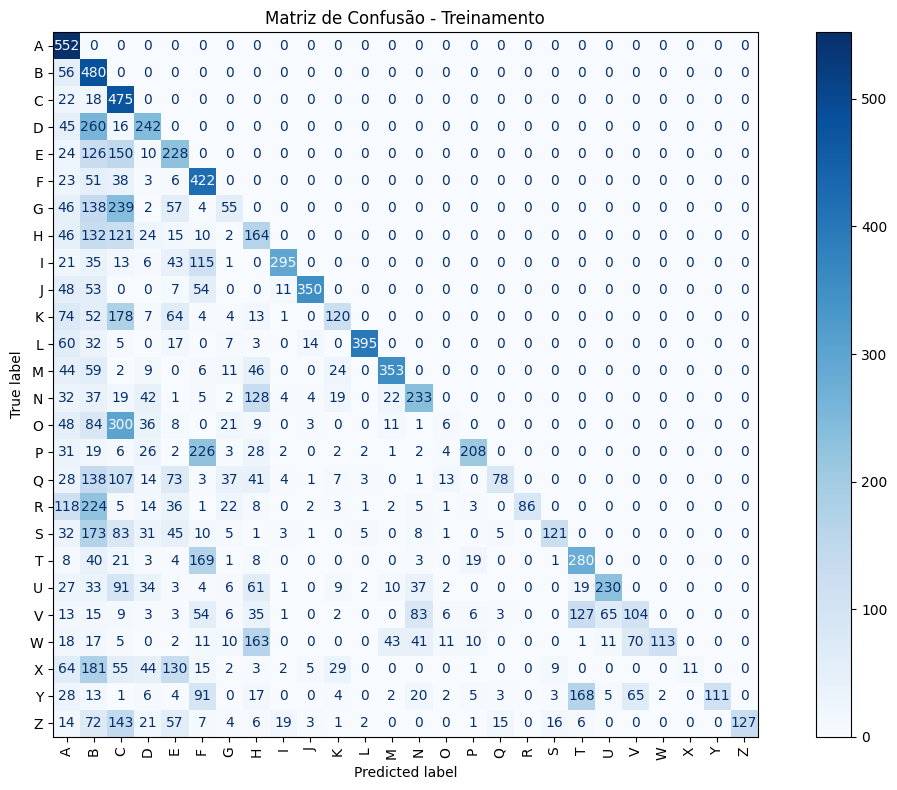

              precision    recall  f1-score   support

           A       0.36      1.00      0.53       552
           B       0.19      0.90      0.32       536
           C       0.23      0.92      0.37       515
           D       0.42      0.43      0.42       563
           E       0.28      0.42      0.34       538
           F       0.35      0.78      0.48       543
           G       0.28      0.10      0.15       541
           H       0.22      0.32      0.26       514
           I       0.86      0.56      0.68       529
           J       0.91      0.67      0.77       523
           K       0.55      0.23      0.33       517
           L       0.96      0.74      0.84       533
           M       0.80      0.64      0.71       554
           N       0.54      0.43      0.47       548
           O       0.13      0.01      0.02       527
           P       0.82      0.37      0.51       562
           Q       0.75      0.14      0.24       548
           R       1.00    

In [7]:

best_model, best_params, best_score, random_search = buscar_melhor_wisard(X_train, y_train)

print("Melhores parâmetros encontrados:", best_params)
print("Melhor acurácia:", best_score)

# Faz predição codificada
y_train_pred_encoded = random_search.predict(X_train)

# Plota matriz de confusão com labels na vertical
plot_confusion_matrix(y_train, y_train_pred_encoded, le, maior = True, title="Matriz de Confusão - Treinamento")

# Imprime relatório de classificação com rótulos originais
classification_metrics(y_train, y_train_pred_encoded, le)

### Predição

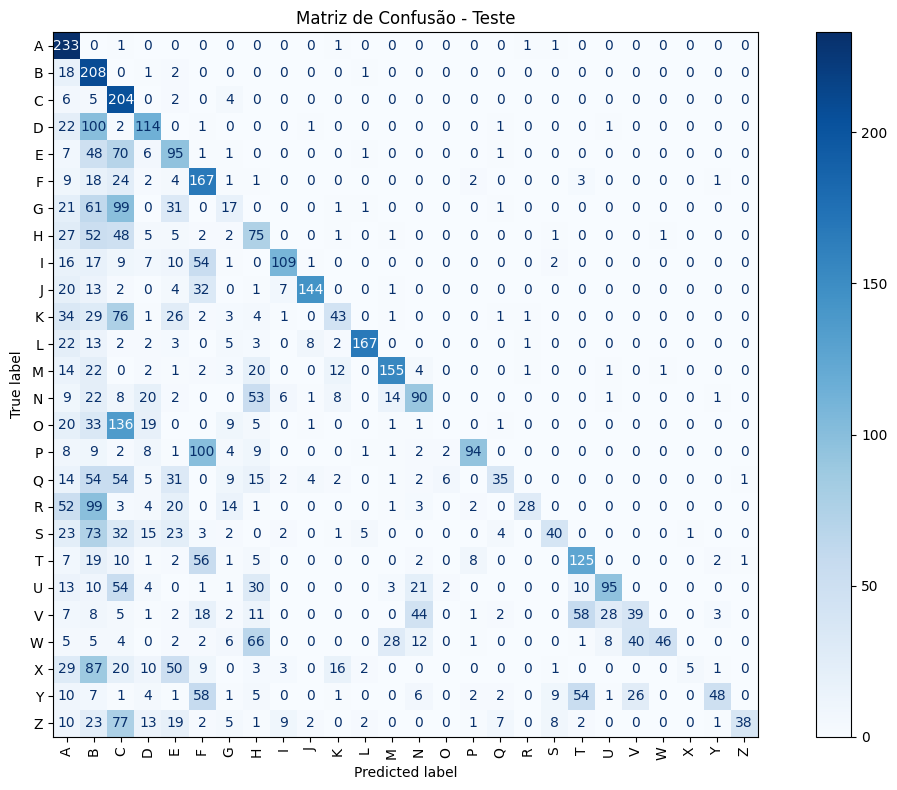

              precision    recall  f1-score   support

           A       0.36      0.98      0.52       237
           B       0.20      0.90      0.33       230
           C       0.22      0.92      0.35       221
           D       0.47      0.47      0.47       242
           E       0.28      0.41      0.34       230
           F       0.33      0.72      0.45       232
           G       0.19      0.07      0.11       232
           H       0.24      0.34      0.28       220
           I       0.78      0.48      0.60       226
           J       0.89      0.64      0.75       224
           K       0.49      0.19      0.28       222
           L       0.93      0.73      0.82       228
           M       0.75      0.65      0.70       238
           N       0.48      0.38      0.43       235
           O       0.00      0.00      0.00       226
           P       0.85      0.39      0.53       241
           Q       0.64      0.15      0.24       235
           R       0.88    

In [8]:
# Predição no teste
y_test_pred = random_search.predict(X_test)

plot_confusion_matrix(y_test, y_test_pred, le, maior = True, title="Matriz de Confusão - Teste")
classification_metrics(y_test, y_test_pred, le)

## MLP

### Tratamento de Dados

In [9]:
X_processed, y_encoded, le = preprocess_data_standart_scale(X, y, categorical_cols, numeric_cols)
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)
# Exibe as dimensões dos conjuntos de treino e teste
print("Tamanho do conjunto de treino:", X_train.shape)
print("Tamanho do conjunto de teste:", X_test.shape)
print("Tamanho dos rótulos de treino:", y_train.shape)
print("Tamanho dos rótulos de teste:", y_test.shape)

print("\nExemplo de X_train (primeiras 5 linhas):")
print(X_train[:5])  # Exibe as 5 primeiras linhas de X_train

print("\nExemplo de y_train (primeiros 5 rótulos):")
print(y_train[:5])  # Exibe os 5 primeiros rótulos de y_train

print("\nExemplo de X_test (primeiras 5 linhas):")
print(X_test[:5])  # Exibe as 5 primeiras linhas de X_test

print("\nExemplo de y_test (primeiros 5 rótulos):")
print(y_test[:5])  # Exibe os 5 primeiros rótulos de y_test

Tamanho do conjunto de treino: (14000, 16)
Tamanho do conjunto de teste: (6000, 16)
Tamanho dos rótulos de treino: (14000,)
Tamanho dos rótulos de teste: (6000,)

Exemplo de X_train (primeiras 5 linhas):
          x-box     y-box     width      high     onpix     x-bar     y-bar  \
1905  -0.535004  0.291877 -0.556881  0.277513 -0.687476  0.050543 -0.645273   
5209  -0.012309 -0.010743 -0.060486 -0.164704 -0.687476  0.544130 -0.215220   
18084  0.510385 -0.313363  1.428701  0.277513  1.138672  0.544130 -1.505378   
2814  -0.012309  0.594497 -0.556881 -0.606921 -0.230939  1.531305 -1.935431   
8075  -1.057698 -1.523844 -0.556881 -1.049137 -0.687476  0.544130 -0.215220   

          x2bar     y2bar     xybar     x2ybr     xy2br     x-ege     xegvy  \
1905   1.248713  0.765028 -0.917071 -0.552641  1.476040 -0.877220 -0.219082   
5209   1.248713  0.765028 -0.515208 -0.172558  0.514764 -0.019764 -0.219082   
18084 -0.232823 -0.495072 -0.515208 -0.932724  0.995402  1.266419 -1.512171   
2814 

### Métricas

In [12]:
random_search = busca_melhores_mlp(X_train, y_train)
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Melhores parâmetros encontrados:", best_params)
print("Melhor acurácia:", best_score)

# Faz predição codificada
y_train_pred_encoded = random_search.predict(X_train)

# Imprime relatório de classificação com rótulos originais
classification_metrics(y_train, y_train_pred_encoded, le)

Melhores parâmetros encontrados: {'mlp__activation_fn': <class 'torch.nn.modules.activation.ReLU'>, 'mlp__dropout_rate': np.float64(0.156732301008724), 'mlp__early_stopping': True, 'mlp__hidden_sizes': (256, 128), 'mlp__learning_rate': np.float64(0.005044203047025815), 'mlp__max_epochs': 252, 'mlp__patience': 10, 'mlp__verbose': False, 'mlp__weight_decay': np.float64(0.0005687115467735005)}
Melhor acurácia: 0.9485714285714284
              precision    recall  f1-score   support

           A       1.00      0.99      0.99       552
           B       0.95      0.97      0.96       536
           C       0.99      0.98      0.98       515
           D       0.95      0.99      0.97       563
           E       0.97      0.98      0.97       538
           F       0.97      0.97      0.97       543
           G       0.99      0.96      0.97       541
           H       0.96      0.93      0.94       514
           I       0.98      0.98      0.98       529
           J       0.99      

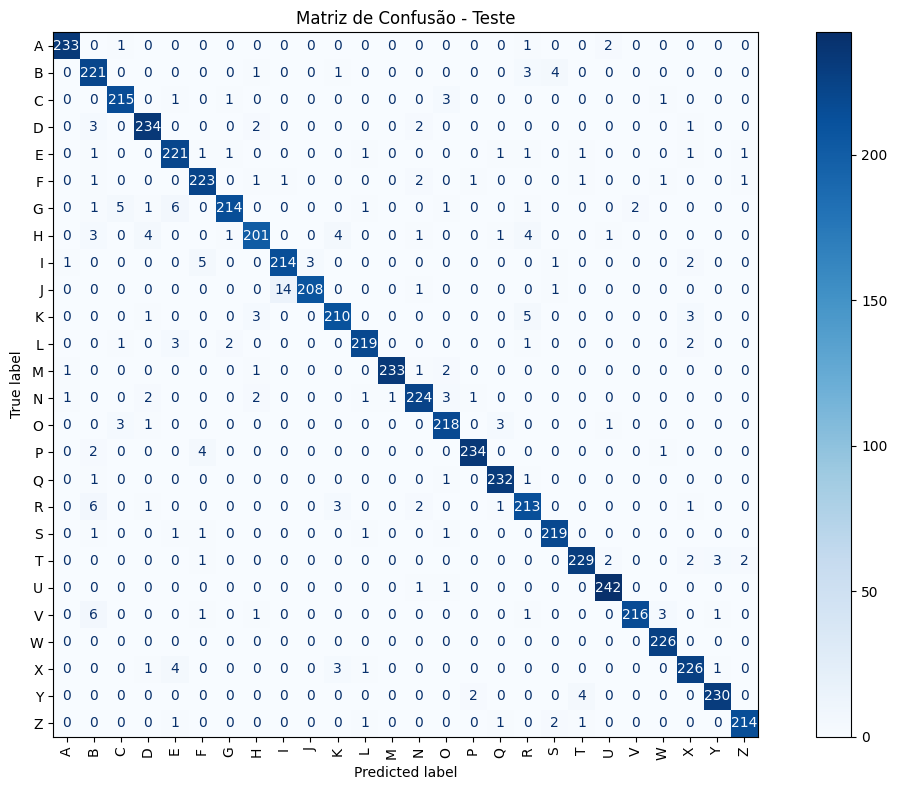

              precision    recall  f1-score   support

           A       0.99      0.98      0.99       237
           B       0.90      0.96      0.93       230
           C       0.96      0.97      0.96       221
           D       0.96      0.97      0.96       242
           E       0.93      0.96      0.95       230
           F       0.94      0.96      0.95       232
           G       0.98      0.92      0.95       232
           H       0.95      0.91      0.93       220
           I       0.93      0.95      0.94       226
           J       0.99      0.93      0.96       224
           K       0.95      0.95      0.95       222
           L       0.97      0.96      0.97       228
           M       1.00      0.98      0.99       238
           N       0.96      0.95      0.96       235
           O       0.95      0.96      0.96       226
           P       0.98      0.97      0.98       241
           Q       0.97      0.99      0.98       235
           R       0.92    

In [13]:
# Predição no teste
y_test_pred = random_search.predict(X_test)

plot_confusion_matrix(y_test, y_test_pred, le, maior = True, title="Matriz de Confusão - Teste")
classification_metrics(y_test, y_test_pred, le)